In [1]:
import re
from collections import OrderedDict
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import torch
import torch.nn.functional as F
from natsort import natsorted
from sklearn.preprocessing import StandardScaler

from fltk.client import Client
from fltk.nets import Cifar10CNN
from fltk.util.base_config import BareConfig

In [2]:
def load_gradients(grad_paths):
    directories = []
    for path in grad_paths:
        try:
            directories.append(torch.load(str(path)))
        except:
            print(path)
    return torch.stack(directories)

In [3]:


def apply_standard_scaler(gradients):
    scaler = StandardScaler()

    return scaler.fit_transform(gradients)

In [4]:
def plot_dataset(directories, poisoned):
    f, axes = plt.subplot(1, 3, 1, share=True, sharey=True)
    for col, indx in enumerate([0, 4, 6]):
        test = directories[:, 551078:552358].view(1300, 10, 128)[:, indx]
        fitter = sklearn.decomposition.PCA(n_components=2)

        scaled_param_diff = apply_standard_scaler(test)
        dim_reduced_gradients = fitter.fit_transform(scaled_param_diff)
        for indx in range(1300):
            axes[col].scatter(dim_reduced_gradients[indx, 0], dim_reduced_gradients[indx, 1],
                              color='r' if poisoned[indx] else 'b')
        plt.show()

In [5]:

def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters.values()]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s + size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return {"params": flat, "indices": indices}


def recover_flattened(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    orderedDict = OrderedDict()
    keys = list(model.state_dict().keys())
    for i, p in enumerate(model.state_dict().values()):
        try:
            l[i] = torch.Tensor(l[i]).view(*p.shape)
            orderedDict[keys[i]] = l[i]
        except:
            print('fail')
            pass
    return l, orderedDict

In [8]:


model = Cifar10CNN()
default_model_path = f"../default_models/Cifar10CNN.model"
model.load_state_dict(torch.load(default_model_path))
flattened_default = flatten_params(model.state_dict())

DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Assi

DEBUG:matplotlib.backends.backend_pdf:Embedding font /home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/home/jeroen/Documents/CSE/MSc/year/1/Q4/CS4290/repo/fltk-testbed-gr-30/venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embe

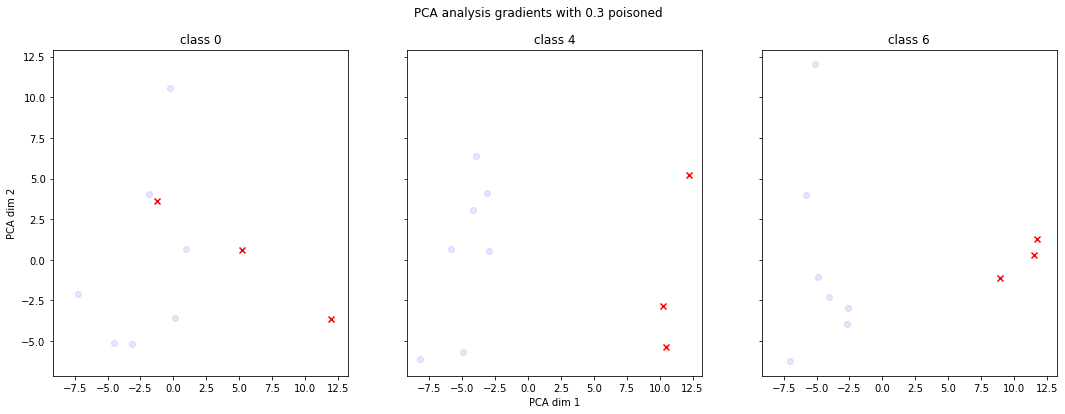

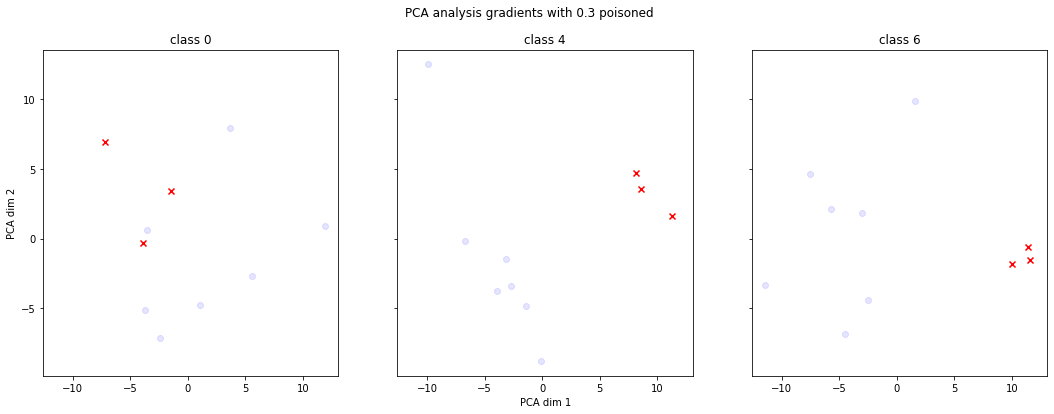

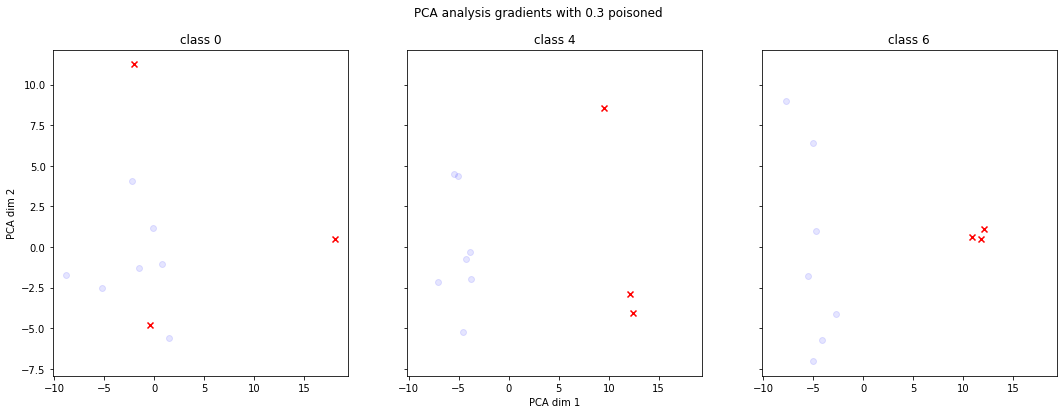

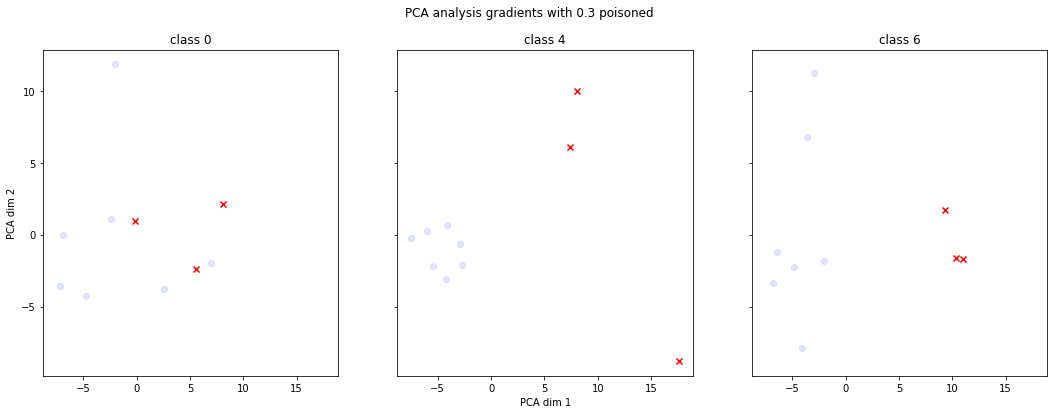

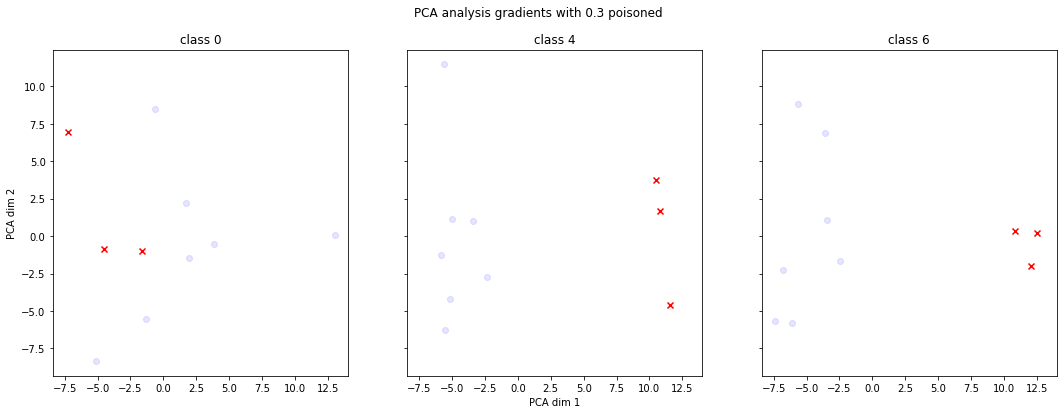

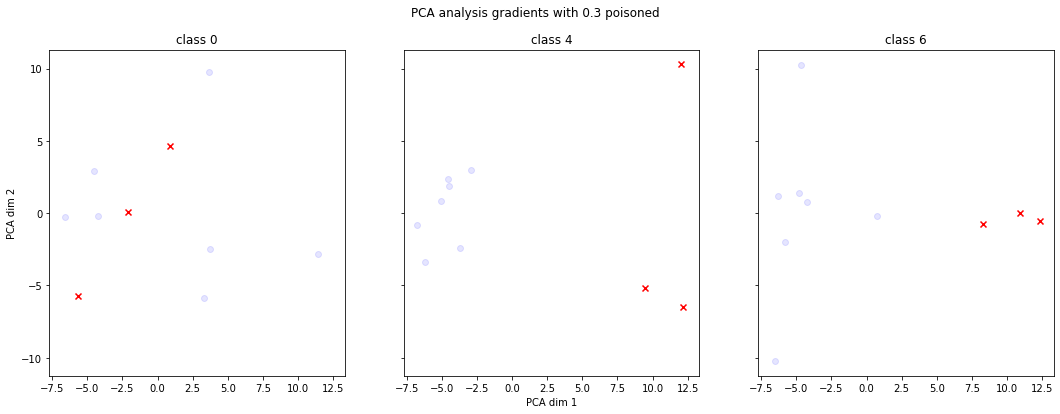

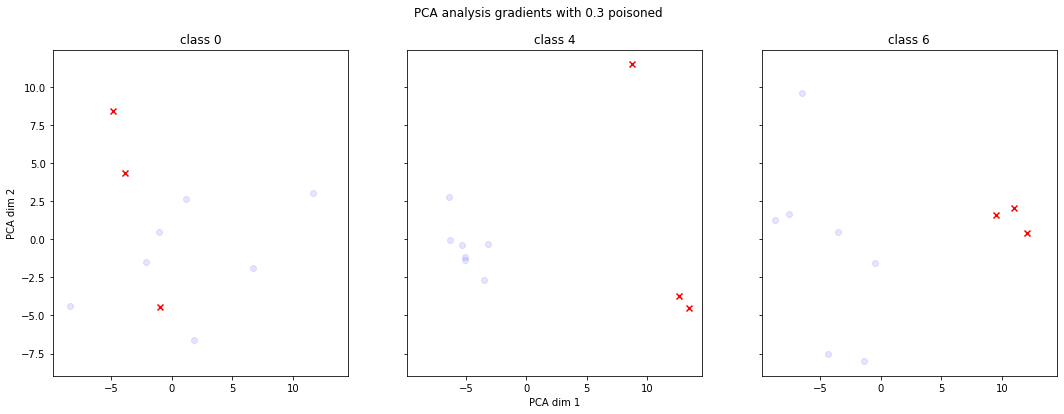

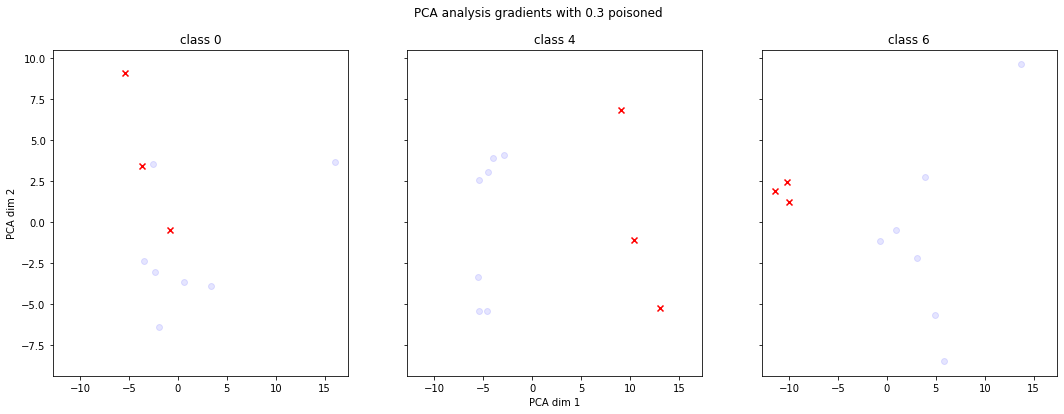

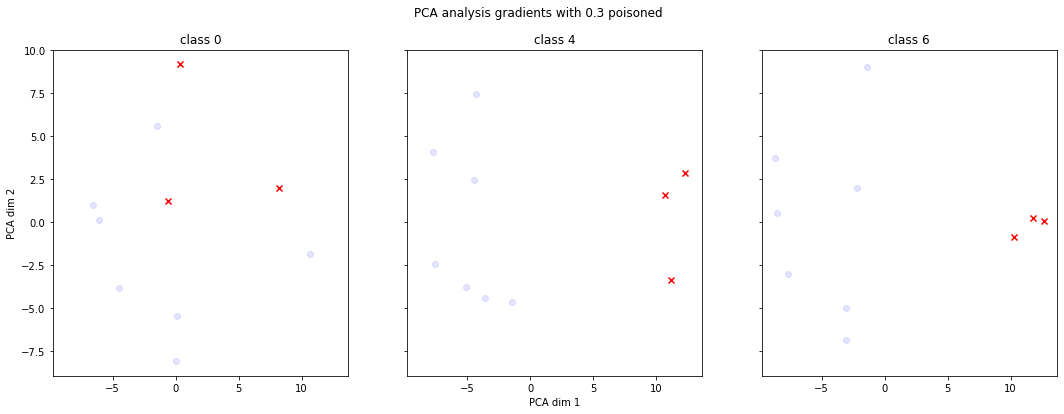

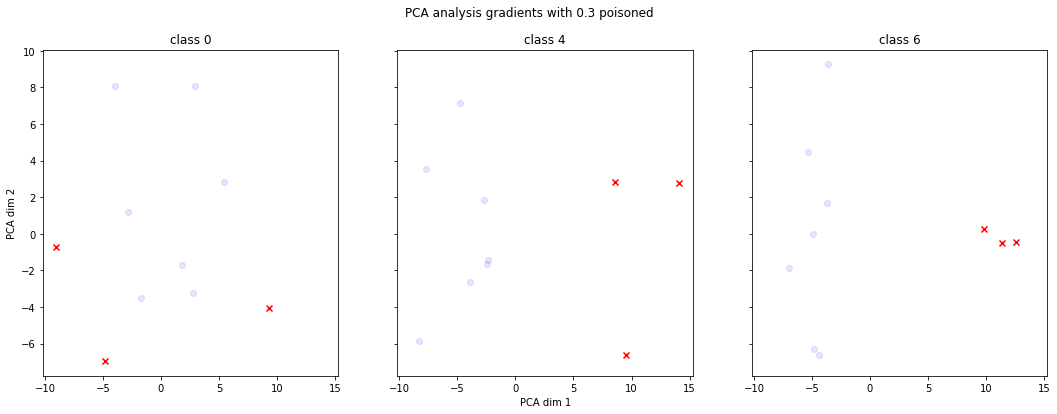

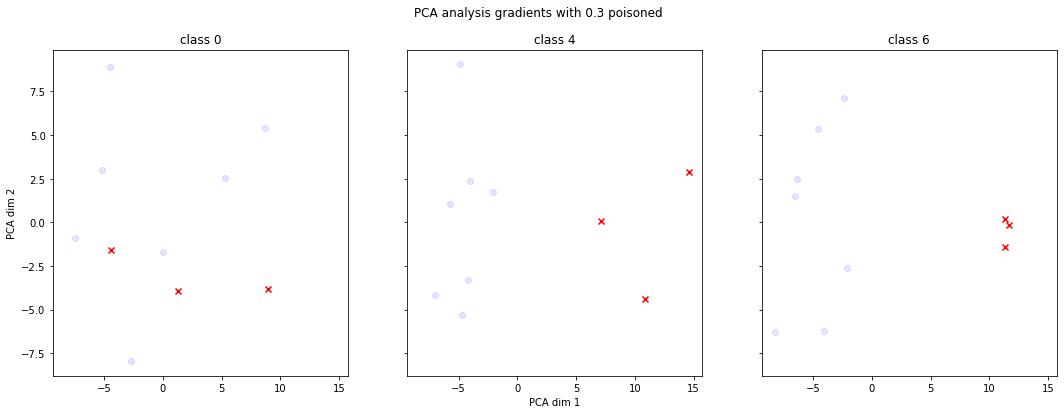

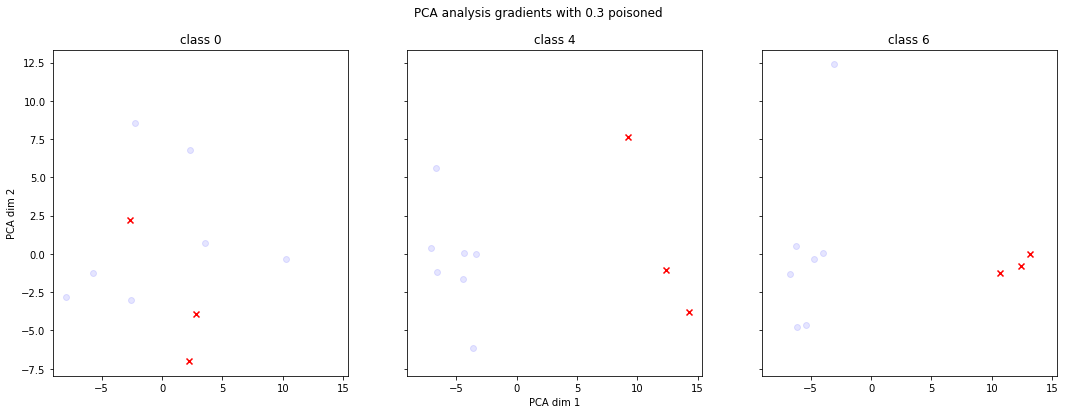

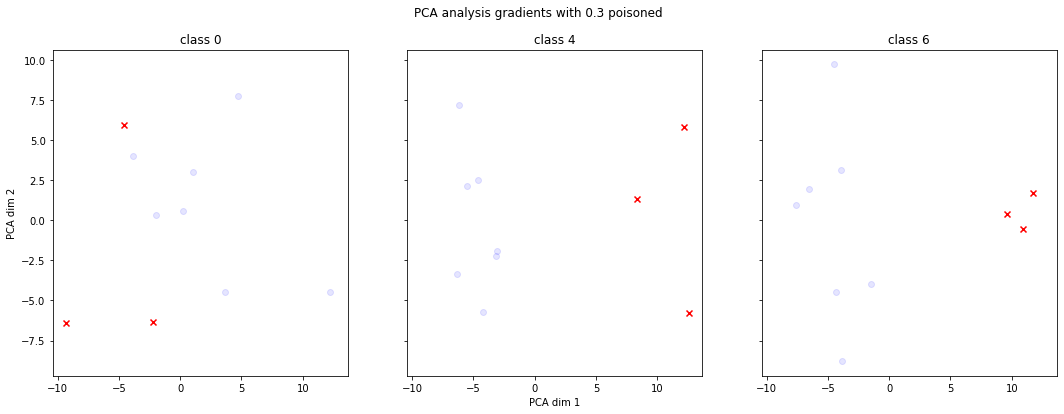

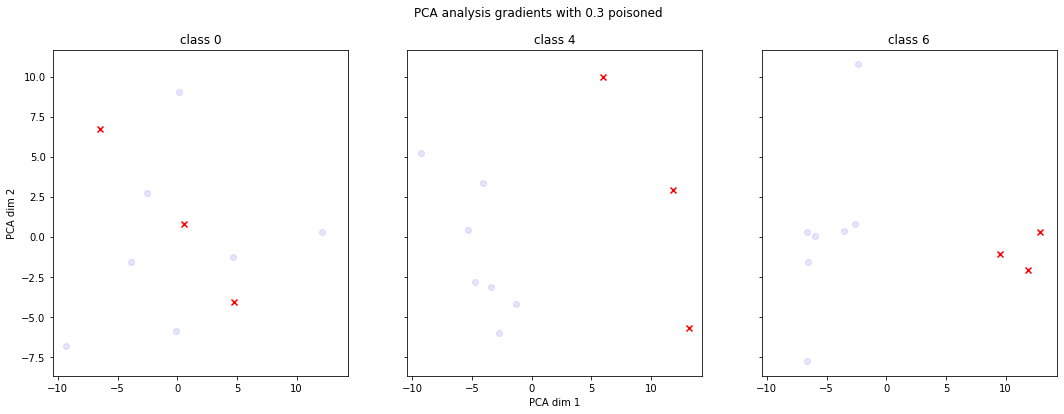

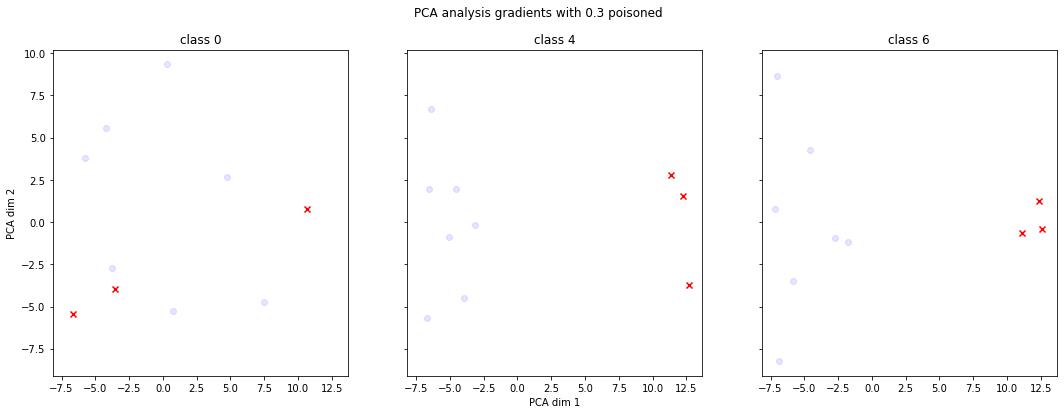

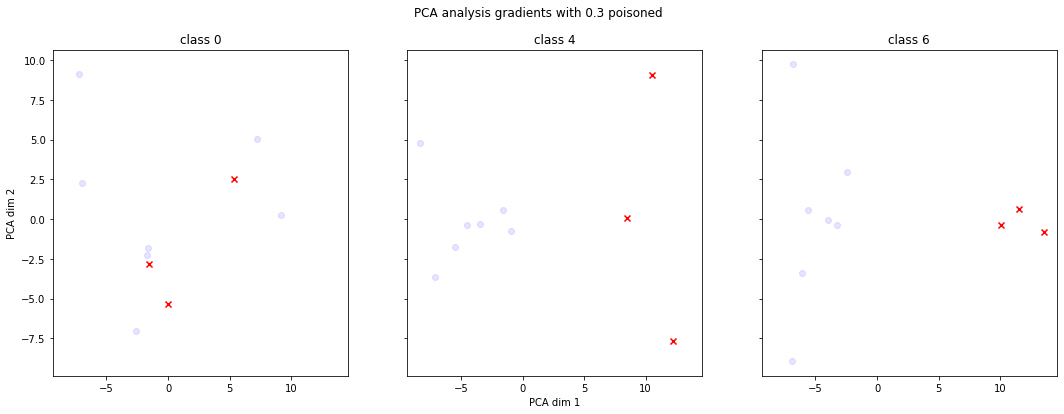

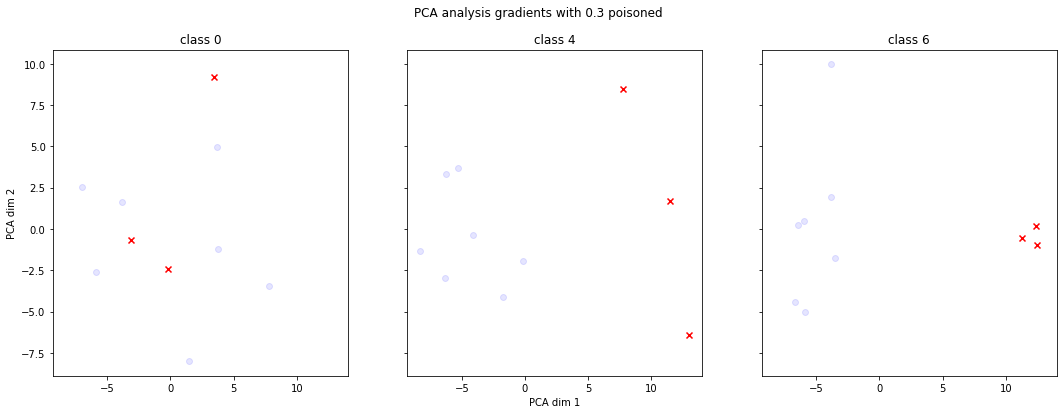

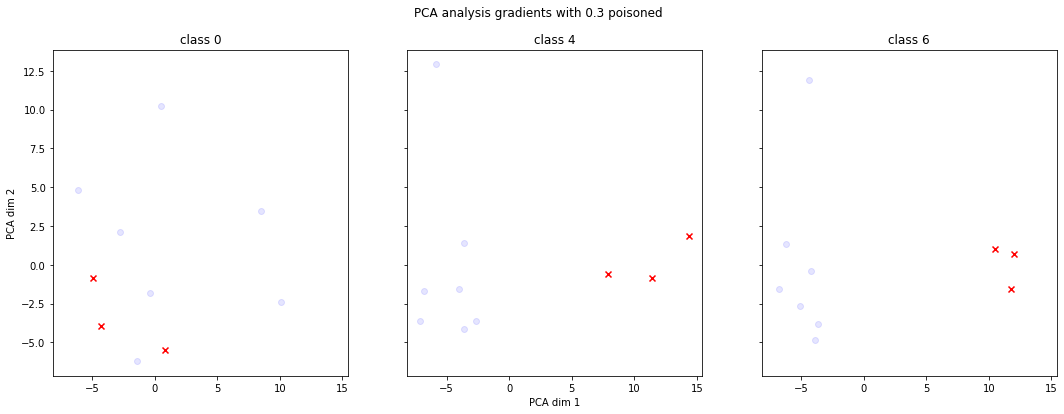

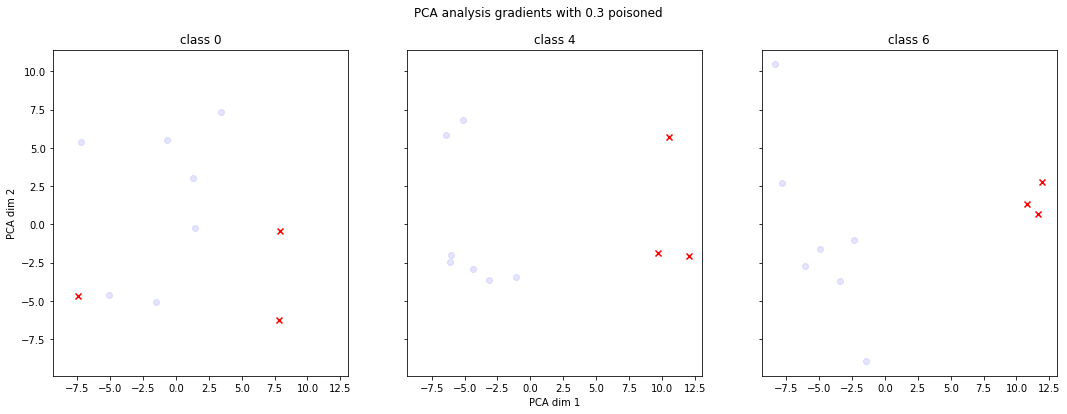

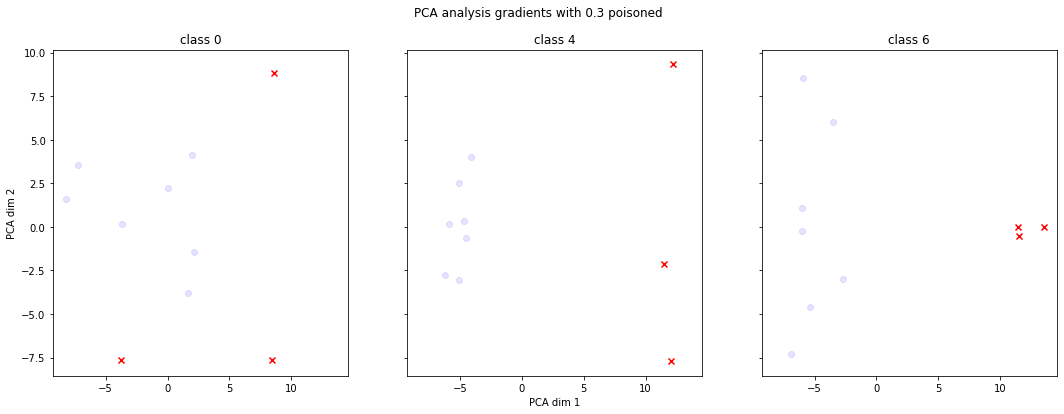

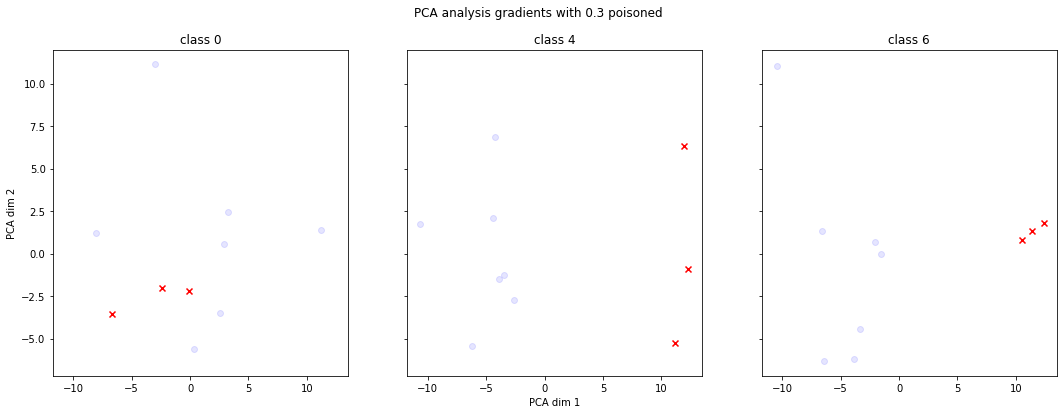

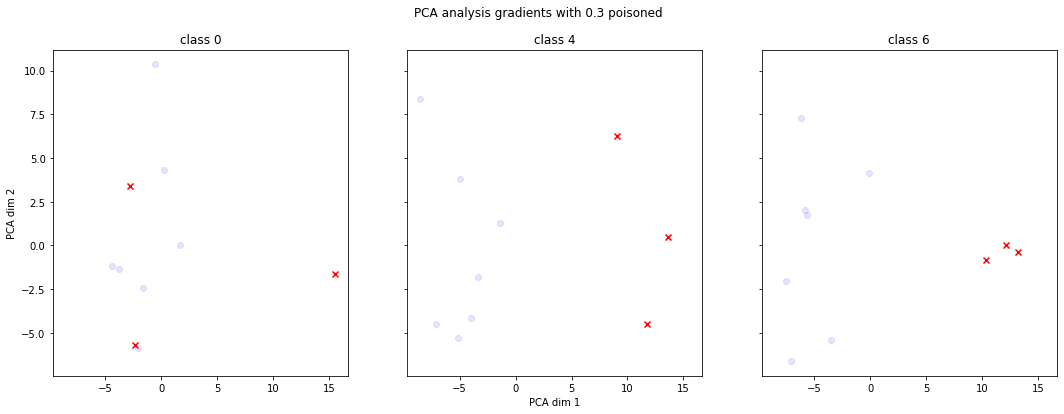

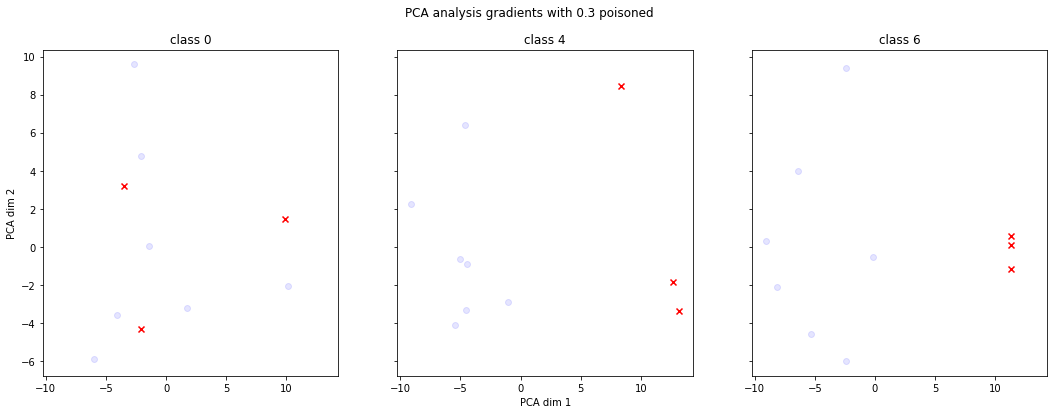

In [15]:
def plot_dataset(directories, poisoned, ratio):
    # The 0.0 fraction is a bit broken
    n = min(len(directories), len(poisoned))
    
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharex=True, sharey=True)
    # Shift title to top
    f.suptitle(f"PCA analysis gradients with {ratio} poisoned")
    # Shared X axis label
    ax[1].set_xlabel('PCA dim 1')
    # Shared y axis label
    ax[0].set_ylabel('PCA dim 2')
    lim_poisoned = poisoned[:n]
    # For non-target/source class, source class, target class
    for col, indx in enumerate([0, 4, 6]):
        test = directories[:n, 551078:552358].view(n, 10, 128)[:, indx]
        fitter = sklearn.decomposition.PCA(n_components=2)

        scaled_param_diff = apply_standard_scaler(test)
        dim_reduced_gradients = fitter.fit_transform(scaled_param_diff)
        ax[col].scatter(dim_reduced_gradients[lim_poisoned.T, 0], dim_reduced_gradients[lim_poisoned.T, 1],
                        color='r',
                        marker='x')
        ax[col].scatter(dim_reduced_gradients[lim_poisoned.T == False, 0], dim_reduced_gradients[lim_poisoned.T == False, 1],
                        color='b',
                        marker='o', alpha=0.1)

    ax[0].title.set_text('class 0')
    ax[1].title.set_text('class 4')
    ax[2].title.set_text('class 6')
    plt.savefig(f'{ratio}.pdf')

# Models the empty language
regex_0 = re.compile("^$")
regex_1 = re.compile("client[9]")
regex_2 = re.compile("client[92]")
regex_3 = re.compile("client[926]")

first_ten_rounds = re.compile("\/([0-9]|10)\/")
for regex, name in [(regex_3, "0.3")]:
    grad_paths = list(Path(f"../charts/extractor/fig8/output_{name}/gradient/").rglob("**/*.pt"))
    grad_paths = [str(path) for path in grad_paths if not any(first_ten_rounds.findall(str(path)))][:-1]
    grad_paths = natsorted(grad_paths)
    poisoned = np.array([any(regex.findall(path)) for path in grad_paths])
#     directories = load_gradients(grad_paths)
    for x in range(1, 24):
        plot_dataset(directories[(x-1)* 10:x*10], poisoned, name)

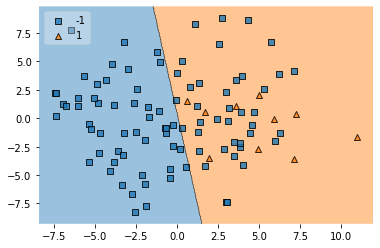

49


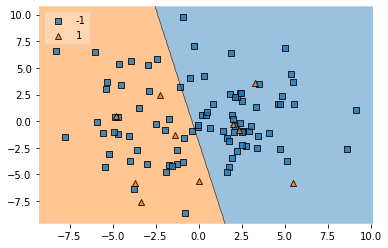

44


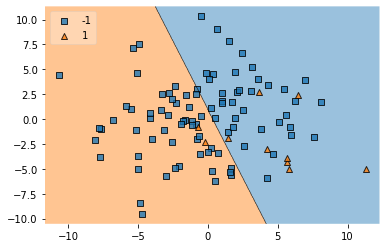

55


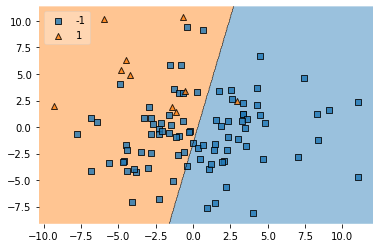

55


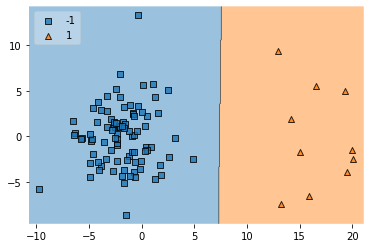

10


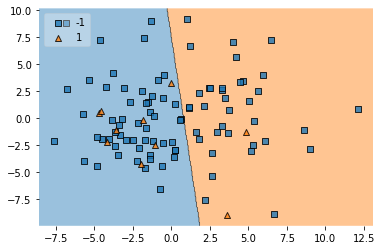

38


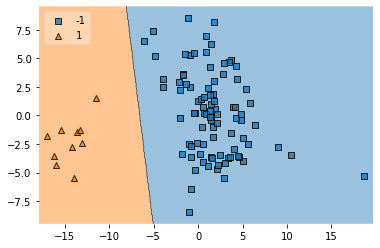

10


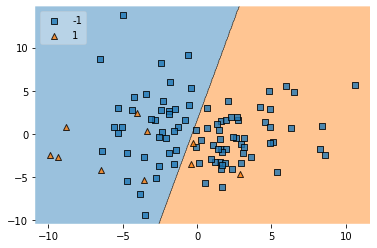

55


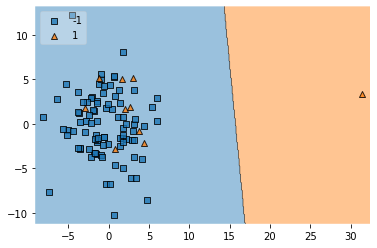

1


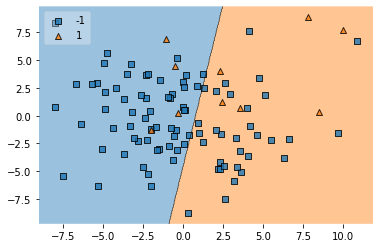

38


In [131]:
till = 100

for x in range(10):
    test = directories[:1199, 551078:552358].view(1199, 10, 128)[:till, x]

    fitter = sklearn.decomposition.PCA(n_components=2)

    scaled_param_diff = apply_standard_scaler(test)
    dim_reduced_gradients = fitter.fit_transform(scaled_param_diff)

    res = dict()
    clf = KMeans(2)
    clf.fit(dim_reduced_gradients)

    plot_decision_regions(X=dim_reduced_gradients, y=poisoned[:till] * 2 - 1, clf=clf, legend=2)
    plt.show()
    print(sum(abs(clf.predict(dim_reduced_gradients))))


In [112]:
from sklearn.metrics import silhouette_score

print(silhouette_score(dim_reduced_gradients, clf.predict(dim_reduced_gradients)))

clf = KMeans(1)
clf.fit(dim_reduced_gradients)

print(silhouette_score(dim_reduced_gradients, clf.predict(dim_reduced_gradients)))

0.33744629551745725


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)